In [92]:
# LUNEDI: ricontrollare metodo opzioni per taxon con depth maggiore di 7 (taxons di sinonimi, sottospecie, etc.)

# TODO: define method to discriminate if an image is allowed to have questions: to_remove, depth<6...(?)
# - symptom, damage no species questions
# - difficulty, other criteria: frequency
# - use captions

# TODO: use wikipedia edible plants: https://en.wikipedia.org/wiki/Edible_plants to create tags for plants

# Note



- In plants, ignore tags: tag-symptoms, eradicate tags: tag-eradication, if tag-invaded-area ask which WEED is this?
- In protista, ignore all tags baby
- In Bacteria, eradicate tag-adult because just two, tag-damage: difficult questions, maybe we can retrieve the attacked species, tag-diagnostic eradictated!!, tag-egg: eRATICATE

In [3]:
import pandas as pd
from tqdm import tqdm
import requests
import urllib
import random
from multiprocessing import Pool
import matplotlib.pyplot as plt
from collections import Counter
import asyncio
import aiohttp
import urllib.parse
from anytree import Node, RenderTree
from random import choice, sample, shuffle

from collections import defaultdict

from PIL import Image, ImageDraw
import requests
from io import BytesIO
import math
from concurrent.futures import ProcessPoolExecutor
from itertools import cycle

import pycountry

- In plants, ignore tags: tag-symptoms, eradicate tags: tag-eradication, if tag-invaded-area ask which WEED is this?
- In protista, ignore all tags baby
- In Bacteria, eradicate tag-adult because just two, tag-damage: difficult questions, maybe we can retrieve the attacked species, tag-diagnostic eradictated!!, tag-egg: eRATICATE

· Plantae
- tag-symptoms: ok
- tag-invaded-area: ask weed identification*
- tag-eradication: remove images

· Protista
- all ok

· Bacteria
- tag-adult: remove images,
- tag-damage: identification is a difficult question, ttry to exploit tags,
- tag-diagnostic: remove images,
- tag-eradication: remove images, 
- tag-larva: remove images, 
- tag-symptoms: ok (seems very good)

· Chromista
- no-tag: ok
- tag-damage: Ask damage cause**
- tag-diagnostic: remove images,
- tag-invaded-are: ok
- tag-symptoms: Ask damage cause

· Animalia
- no-tag: ok (a little noisy)
- tag-adult: Ask growth stage***
- tag-damage: Ask damage cause
- tag-diagnostic: remove images
- tag-egg: ok
- eggs: ok
- tag-eradication : remove images
- taginvaded-area: ok
- 'larva': Ask growth stage
- 'pupa': Ask growth stage
- 'symptoms': Ask damage cause

. Fungi
- no-tag: ok
- tag-damage: Ask damage cause
- tag-diagnostic: remove images
- tag-symptoms: Ask damage cause

virsu
- no-tag: damage cause
- tag-adult: remove_images
- tag-damage: damage cause
- tag-diagnostic: remove images
- tag-eggs: ok
- tag-symptoms: damage cause

new_questions = [*weed_identification, **damage_cause, ***growth_stage]





In [4]:
kingdoms = [
 'Archaea',
 'Bacteria',
 'Chromista',
 'Viruses_and_viroids',
 'Fungi',
 'Protista',
 'Plantae',
 'Animalia']

dfs = {'EPPO':{}, 'GBIF':{}, 'GBIF_unique':{}}

root_dir_eppo = '/workdir/important_datasets/EPPO Dataframes/Kingdom/'
root_dir_gbif = '/workdir/important_datasets/EPPO_to_GBIF/'

for kingdom in kingdoms:
    df_file_path = root_dir_gbif+f'df.{kingdom}_EPPO_to_GBIF.gzip'
    df = pd.read_parquet(df_file_path, engine='pyarrow')
    numeric_cols = df.select_dtypes(include=['number']).columns
    dfs['GBIF'][kingdom] = df.astype({col: 'Int64' for col in numeric_cols})
    #### Merge EPPO Codes
    # Raggruppa le righe per 'key' e considera solo quelle con più di una riga
    dfs['GBIF'][kingdom]['original_order'] = dfs['GBIF'][kingdom].index
    result = (
        dfs['GBIF'][kingdom]
        .groupby('key', as_index=False)
        .agg({
            'EPPO_code': list,  # Aggregate 'code' into lists
            **{col: 'first' for col in dfs['GBIF'][kingdom].columns if col not in ['key', 'EPPO_code']}  # Keep other columns
        })
    )
    dfs['GBIF_unique'][kingdom] = result.sort_values('original_order').drop(columns='original_order')
    
    
    df_file_path = root_dir_eppo+f'df.{kingdom}.EPPO.gzip'
    df = pd.read_parquet(df_file_path, engine='pyarrow')
    numeric_cols = df.select_dtypes(include=['number']).columns
    dfs['EPPO'][kingdom] = df.astype({col: 'Int64' for col in numeric_cols})

In [5]:
# def get_taxonomic_path_row(row):
    
#     if pd.isna(row['key']):
#         return {}
    
#     columns = ['EPPO_code', 'key']
#     new_row = {column: row[column] for column in columns}
#     name = (row.get('canonicalName') if row.get('canonicalName') else row.get('scientificName'))
#     key = row['key']
#     classification_map = (row['higherClassificationMap'])
#     if classification_map:
#         classification_map_dict = eval(row['higherClassificationMap'])
#         classification_map = list(classification_map_dict.items())
#         classification_map += [(str(key), name)]
#         new_row['taxonomic_path'] = classification_map
#     return new_row


# def get_taxonomic_path(df):
#     data = [get_taxonomic_path_row(row) for _, row in df.iterrows()]
#     return pd.DataFrame(data)

# trees={}
# for kingdom in kingdoms:
#     df_paths = get_taxonomic_path(dfs['GBIF'][kingdom])
#     paths = [row['taxonomic_path'] for _, row in df_paths.iterrows() if isinstance(row['taxonomic_path'], list)]
#     root = Node("root")
#     nodes = {}

#     for path in paths:
#         parent = root
#         for node in path:
#             if node not in nodes:
#                 nodes[node] = Node(node, parent=parent)
#             parent = nodes[node]
#     trees[kingdom]=nodes

In [6]:
to_remove = {
    'Plantae': ['tag-eradication'],
    'Bacteria': ['tag-adult', 'tag-diagnostic', 'tag-eradication', 'tag-larva'],
    'Chromista': ['tag-diagnostic'],
    'Animalia': ['tag-diagnostic', 'tag-eradication'],
    'Fungi': ['tag-diagnostic'],
    'Viruses_and_viroids': ['tag-adult', 'tag-diagnostic']
}

weed_identification =  {
    'Plantae': ['tag-invasive-area']
}

damage_cause =  {
    'Bacteria': ['tag-damage'],
    'Chromista': ['tag-damage','tag-symptoms'],
    'Animalia': ['tag-damage', 'tag-symptoms'],
    'Fungi': ['tag-damage', 'tag-symptoms'],
    'Viruses_and_viroids': ['','tag-damage', 'tag-symptoms']   
}

growth_stage =  {
    'Animalia': ['tag-adult', 'tag-larva', 'tag-pupa'], 
}

In [7]:
def plot_tag_histogram(count_tags, title):
    """
    Plots a histogram from a dictionary of tag counts.
    
    Parameters:
    - tag_counts (dict): A dictionary where keys are tags and values are their respective counts.
    """
    tags = list(count_tags.keys())
    counts = list(count_tags.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(tags, counts, color='skyblue', edgecolor='black')
    plt.xlabel('Tags', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def count_tags(EPPO_images):
    count_tags = {kingdom: defaultdict(int) for kingdom in kingdoms}

    for kingdom in kingdoms:
        for image in EPPO_images[kingdom]:
            for tag in image.tag:
                count_tags[kingdom][tag] += 1

    count_tags = {kingdom: dict(value) for kingdom, value in count_tags.items()}
    return count_tags

In [8]:
def get_kingdom_word(kingdom):
    if kingdom == 'Plantae':
        return 'plant'
    elif kingdom == 'Animalia':
        return 'animal'
    elif kingdom == 'Fungi':
        return 'fungus'
    elif kingdom == 'Bacteria':
        return 'bacterium'
    elif kingdom == 'Archaea':
        return 'archaeon'
    elif kingdom == 'Protista':
        return 'protist'
    elif kingdom == 'Chromista':
        return 'chromist'
    elif kingdom == 'Viruses_and_viroids':
        return 'virus'
    else:
        return

In [9]:
def update_kwargs(kwargs):
    if 'kingdom' in kwargs:
        kwargs.update({'kingdom_word': get_kingdom_word(kwargs['kingdom'])})
    return kwargs

In [10]:
def get_common_names(eppo_list, row_gbif):
    languages_gbif=defaultdict(set)
    gbif_cnames=eval(str(row_gbif.get('vernacularNames','[]')))
    eppo_cnames = []
    for row_eppo in eppo_list:
        
        eppo_cnames += eval(str(row_eppo.get('Common names','[]')))
    if gbif_cnames:
        for gbif_cname in gbif_cnames:
            language=gbif_cname.get('language','')
            if language:
                languages_gbif[pycountry.languages.get(alpha_3=language).name].add(gbif_cname['vernacularName'].lower())
    if eppo_cnames:
        for eppo_cname in eppo_cnames:
            value = list(eppo_cname.items())[0][0]
            lang = list(eppo_cname.items())[0][1]
            languages_gbif[lang].add(value)
    return dict(languages_gbif)

def adjust_common_names(row_eppo):
    languages=defaultdict(set)
    for eppo_cname in row_eppo:
        value = list(eppo_cname.items())[0][0]
        lang = list(eppo_cname.items())[0][1]
        languages[lang].add(value)
    return dict(languages)
    

In [11]:
class EPPOImage():
    def __init__(self, image, taxon, eppo_row):
        self.image_path = image['url']
        self.tag = image['tag']
        self.caption = image['cap']
        self.eppo_row = eppo_row
        self.common_names = adjust_common_names(eval(str(eppo_row.get('Common names','[]'))))
        self.taxon = taxon
    
    def __str__(self):
        # Start by defining the order of attributes
        ordered_attrs = [
            ('Image_path', self.image_path if hasattr(self, 'image_path') else None),
            ('Tag', self.tag),
            ('Caption', self.caption),
        ]

        # Add any other attributes dynamically (if any)
        for attr in dir(self):
            if not callable(getattr(self, attr)) and not attr.startswith("__") and attr not in ['image_path', 'tag', 'caption', 'correct_answer']:
                ordered_attrs.append((attr.capitalize(), getattr(self, attr)))

        # Format and return the string in the correct order
        formatted_attrs = '\n'.join(f"{key}: {value}" for key, value in ordered_attrs if value is not None)
        response = requests.get(self.image_path)
        image = Image.open(BytesIO(response.content))
        plt.imshow(image)
        plt.axis('off')  # Turn off axis labels
        plt.show()
        return formatted_attrs
    
    def valid_growth_stage(self):
        growth_stages = ['tag-adult', 'tag-larva', 'tag-pupa', 'tag-egg', 'tag-eggs']
        possible_tag = []
        for tag in self.tag:
            if tag in growth_stages:
                possible_tag.append(tag)
        if len(possible_tag) == 1:
            valid_tag = possible_tag[0][4:] #cut 'tag-' prefix
            if valid_tag.startswith('egg'):
                valid_tag = 'egg'
            return valid_tag
    
    def get_templates(self):
        rank=self.taxon.get_attr('rank')
        kingdom=self.taxon.kingdom
        common_names = self.common_names
        if rank=='GENUS':
            default_templates = {'genus_name'}
        else:
            default_templates = {'scientific_name'}
        if common_names:
            default_templates.add('common_name')    
        for tag in self.tag:
            if tag in to_remove.get(kingdom,[]):
                return {}
            elif tag in weed_identification.get(kingdom,[]):
                return {'weed_identification'}
            elif tag in damage_cause.get(kingdom,[]):
                return {'damage_cause'}
            elif tag in growth_stage.get(kingdom,[]):
                if self.valid_growth_stage():
                    default_templates.add('growth_stage')

        return default_templates

class Taxon():
    def __init__(self, gbif_key, row_eppo, row_gbif, kingdom, index, node=None, trees=[], dfs=dfs, eppo_list=[]):
        self.gbif_key = gbif_key
        #self.taxontree = trees[kingdom]
        self.name  = str(row_gbif.get('canonicalName') if row_gbif.get('canonicalName') else row_gbif.get('scientificName'))
        self.kingdom = kingdom
        self.index = index
        self.df_eppo = dfs['EPPO'][kingdom]
        self.df_gbif = dfs['GBIF'][kingdom]
        self.row_eppo = row_eppo
        self.row_gbif = row_gbif
        self.eppo_list = eppo_list
        self.common_names =get_common_names(eppo_list, row_gbif) # change to eppo_list
        self.node = node
        
    def get_attr(self, attr, fallback=None):
        if pd.isna(self.row_eppo.get(attr)) and pd.isna(self.row_gbif.get(attr)):
            return fallback
        elif self.row_eppo.get(attr):
            return self.row_eppo.get(attr)
        elif self.row_gbif.get(attr):
            return self.row_gbif.get(attr)
        else:
            if fallback is None:
                print('Svegliaaaa attributo inesistente')
            return fallback
    
    # def get_node(self):
    #     key = str(self.get_attr('key'))
    #     name = str(self.get_attr('canonicalName') if self.get_attr('canonicalName') else self.get_attr('scientificName'))
    #     return self.taxontree.get((key, name))
    
    def get_random_neighbors(self, distance, num=3, with_balance_info=False):
        # if not self.get_node():
        #     print(self)
        nodes = get_random_neighbors_node(self.node, distance, num, with_balance_info)
        options = [node.name[1] for node in nodes]
        return  options
             
    def __str__(self):
        return self.get_attr('canonicalName', '')
    
def find_node(key, taxons):
    for tax in taxons:
        if not pd.isna(tax.gbif_key):
            if tax.gbif_key==key:
                return tax

def get_random_neighbors_node(node, distance, num=3, with_balance_info=False):
    if node.depth<=4:
        return []
    
    if node.depth>7:
        distance=distance+1
        max_depth=node.depth+1
        min_depth=7
    else:
        max_depth=node.depth+1
        min_depth=node.depth
    ancestor = node.ancestors[-distance]
    if distance == 0:
        return []
    if distance == 1:
        if len(ancestor.children) - 1 < num:
            return []
        return sample([child for child in ancestor.children if child != node], num)
    
    intermediate_ancestor = node.ancestors[-distance + 1]
    sub_ancestors = [child for child in ancestor.children if child != intermediate_ancestor]
    shuffle(sub_ancestors)
    
    neighbors = []
    sub_ancestor_cycle = cycle(sub_ancestors)  # Cycle through sub_ancestors
    found=0
    
    for sub_ancestor in sub_ancestor_cycle:
        if len(neighbors) >= num or found>len(sub_ancestors):
            break
        descendants = list(descendant for descendant in sub_ancestor.descendants)
        shuffle(descendants)
        for descendant in descendants:
            if min_depth <= descendant.depth <max_depth and descendant not in neighbors:
                neighbors.append(descendant)
                found=0
                break
        found +=1 
        
    
    # if equidistant neighbors is not ensured balanced is False
    if with_balance_info:
        return {'result': neighbors, 'balanced': (len(sub_ancestors) >= num)}
    
    return neighbors    

def get_neighbors_common_names(node, taxons ,distance, kingdom='Plantae',num=3, language=''):
    if node.depth<=4:
        return []
    
    if node.depth>7:
        distance=distance+1
        max_depth=node.depth+1
        min_depth=7
    else:
        max_depth=node.depth+1
        min_depth=node.depth
    ancestor = node.ancestors[-distance]
    if distance == 0:
        return []
    options_names=[]
    if distance == 1:
        if len(ancestor.children) - 1 < num:
            return []
        children=list(ancestor.children)
        shuffle(children)
        for child in children:
            if child != node and len(child.name)==3:
                #print(child.name)
                child_taxon=child.name[-1]
                if child_taxon:
                    names=child_taxon.common_names
                    if language in names:
                        options_names.append(choice(list(names.get(language))))
            if len(options_names)>2:
                return sample(options_names, num)
    
    intermediate_ancestor = node.ancestors[-distance + 1]
    sub_ancestors = [child for child in ancestor.children if child != intermediate_ancestor]
    shuffle(sub_ancestors)
    
    neighbors = []
    sub_ancestor_cycle = cycle(sub_ancestors)  # Cycle through sub_ancestors
    found=0
    
    for sub_ancestor in sub_ancestor_cycle:
        if len(options_names) >= num or found>len(sub_ancestors):
            break
        descendants = list(descendant for descendant in sub_ancestor.descendants)
        shuffle(descendants)
        for descendant in descendants:
            if min_depth <= descendant.depth <max_depth and descendant not in neighbors:
                neighbors.append(descendant)
                descendant_taxon=descendant.name[-1]
                if descendant_taxon and len(descendant.name)==3:
                    names = descendant_taxon.common_names
                    if language in names:
                        options_names.append(choice(list(names.get(language))))
                        found=0
                        break
        found +=1 
    
    return options_names   


In [12]:
question_templates = {
    'scientific_name':      'What is the scientific name of this {kingdom_word}?',
                        
    'common_name':          'What is the common name in {language} of this {kingdom_word}?',
                        
    'genus_name':           'Which genus does this {kingdom_word} belong to?',
                        
    'major_pest':           'Which of the following is a major pest of this plant?',
        
    'weed_identification':  'What is the scientific name of the invasive weed in this image?',
    
    'damage_cause':         'What is the scientific name of the {kingdom_word} causing this damage?', #tag-symptom, tag-damage
    
    'growth_stage':         'At what growth stage is this {kingdom_word}?',
}

class Question:
    def __init__(self, question='', options=[], correct_answer='', difficulty=0):
        self.correct_answer = correct_answer
        self.options = options
        self.difficulty = difficulty
        self.question = question

    def print_question(self):
        return {
            'question': self.question,
            'options': self.options,
            'correct_answer': self.correct_answer,
            'difficulty': self.difficulty
        }
    
    def __str__(self):
        # Start by defining the order of attributes
        ordered_attrs = [
            ('Kingdom', self.kingdom if hasattr(self, 'kingdom') else None),
            ('Image_path', self.image_path if hasattr(self, 'image_path') else None),
            ('Question', self.question),
            ('Options', self.options),
            ('Correct_answer', self.correct_answer),
        ]

        # Add any other attributes dynamically (if any)
        for attr in dir(self):
            if not callable(getattr(self, attr)) and not attr.startswith("__") and attr not in ['kingdom', 'image_path', 'question', 'options', 'correct_answer']:
                ordered_attrs.append((attr.capitalize(), getattr(self, attr)))

        # Format and return the string in the correct order
        formatted_attrs = '\n'.join(f"{key}: {value}" for key, value in ordered_attrs if value is not None)
        return formatted_attrs

class IdentificationQuestion(Question):
    def __init__(self, tag='', question_template='', options=[], correct_answer='', difficulty=0, image_path='', **kwargs):
        
        self.question_template = question_template
        self.tag = tag
        
        if not self.question_template and self.tag:
            self.question_template = question_templates[self.tag]
            
        self.image_path = image_path
        self.kwargs = kwargs

        
        for key, value in kwargs.items():
            setattr(self, key, value)
        super().__init__(question_template,  options, correct_answer, difficulty)
        
    def update(self, **extra_kwargs):

        self.kwargs.update(extra_kwargs)
        self.kwargs = update_kwargs(self.kwargs)
        self.question = self.question_template.format(**self.kwargs)
        
        for key, value in self.kwargs.items():
            setattr(self, key, value)
        return self       


# Store Taxons and Images

In [13]:

taxons = {}
EPPO_images = {}

for kingdom in kingdoms:
    encountered_keys = {}
    taxons[kingdom] = []
    EPPO_images[kingdom] = []
    
    for (i,e) , (j,g) in tqdm(zip(dfs['EPPO'][kingdom].iterrows(),dfs['GBIF'][kingdom].iterrows())):
        if pd.isna(g['key']):
            continue 
        key = g['key']
        if key not in encountered_keys:
            #print(e)
            taxon = Taxon(g['key'],e,g,kingdom,j,eppo_list=[e])
            encountered_keys[key] = taxon
            taxons[kingdom].append(taxon)
        else:
            taxon = encountered_keys[key]
            taxon.eppo_list.append(e)
        images = eval(taxon.get_attr('Images', '[]'))
        
        if images:
            for image in images:
                eppo_image = EPPOImage(image, taxon, e)
                EPPO_images[kingdom].append(eppo_image)

13it [00:00, 1615.63it/s]
1029it [00:00, 3235.84it/s]
592it [00:00, 2818.31it/s]
1909it [00:00, 6063.66it/s]
8327it [00:02, 3953.54it/s]
89it [00:00, 5064.69it/s]
58298it [00:17, 3383.95it/s]
27501it [00:07, 3835.87it/s]


In [14]:
def get_taxonomic_path_row(taxon):
    #eppo_codes = [eppo['EPPO Code'] for eppo in taxon.eppo_list]
    #new_row = {'eppo_list':eppo_codes,'key':taxon.gbif_key}
    
    name = taxon.name
    key = taxon.gbif_key
    
    classification_map = (taxon.get_attr('higherClassificationMap'))
    if classification_map:
        classification_map_dict = eval(classification_map)
        classification_map = list(classification_map_dict.items())
        classification_map += [(str(key), name, taxon)]
    return classification_map

trees={}
for kingdom in tqdm(kingdoms):
    paths=[]
    for taxon in taxons[kingdom]:
        paths.append(get_taxonomic_path_row(taxon))
    
    root = Node("root")
    nodes = {}

    for path in paths:
        parent = root
        for node in path:
            key = node[:2]
            if key not in nodes:
                nodes[key] = Node(node, parent=parent)
            else:
                # If key exists but the current node has a Taxon object, replace it
                existing_node = nodes[key]
                if len(node) > len(existing_node.name):  # Assuming Taxon object makes the tuple longer
                    nodes[key] = Node(node, parent=existing_node.parent)
                    for child in existing_node.children:
                        child.parent = nodes[key]
            parent = nodes[key]
    trees[kingdom]=nodes
    #print('Updating taxon node of', kingdom)
    for taxon in taxons[kingdom]:
        taxon.node = trees[kingdom][(str(taxon.gbif_key),str(taxon.name))]

100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


In [15]:
def get_question(image, question_template, difficulty, num_options=3, language=''):
    
    image_path = image.image_path
    taxon = image.taxon
    if question_template.tag == 'growth_stage':
        
        correct_answer = image.valid_growth_stage()
        if not correct_answer:
            print('No valid growth stage!')
            return
        options = ['egg', 'larva', 'pupa', 'adult']
        
    elif question_template.tag == 'common_name':
        
        correct_answer = choice(list(image.common_names.get(language)))
        options=[]
        options = get_neighbors_common_names(taxon.node,taxons,kingdom=taxon.kingdom, distance=6-difficulty, language=language)
        if len(options) < num_options:
            return
        options.append(correct_answer)
        
    else:
        correct_answer = str(taxon.get_attr('canonicalName') if taxon.get_attr('canonicalName') else taxon.get_attr('scientificName'))
        options = taxon.get_random_neighbors(6-difficulty, num=num_options)
        if len(options) < num_options:
            return
        options.append(correct_answer)
        
    shuffle(options)
    
    question_template.update(options=options, correct_answer=correct_answer, difficulty=difficulty, image_path=image_path, kingdom=taxon.kingdom,language=language)
    
    return question_template

In [ ]:
errors={}
questions={}
c = 0

for kingdom in kingdoms:
    r = 0
    tot=0
    errors[kingdom]={}
    questions[kingdom]={}
    print(kingdom,'TQDMs')
    difficulty=5
    errors[kingdom][difficulty] = 0
    questions[kingdom] = []
    for image in tqdm(EPPO_images[kingdom]):
        templates=image.get_templates()
        for template in templates:
            q_temp = IdentificationQuestion(template)
            if 'English' in list(image.common_names.keys()):
                language = 'English'
            elif list(image.common_names.keys()):
                language=list(image.common_names.keys())[0]
            else:
                language=''
            quest = get_question(image, q_temp, difficulty=difficulty, language=language)
            if quest:
                questions[kingdom].append(quest)

Archaea TQDMs


0it [00:00, ?it/s]


Bacteria TQDMs


100%|██████████| 1910/1910 [00:00<00:00, 7536.11it/s]


Chromista TQDMs


100%|██████████| 330/330 [00:00<00:00, 9207.09it/s]


Viruses_and_viroids TQDMs


100%|██████████| 751/751 [00:00<00:00, 10454.82it/s]


Fungi TQDMs


100%|██████████| 1692/1692 [00:00<00:00, 8386.28it/s]


Protista TQDMs


100%|██████████| 11/11 [00:00<00:00, 8962.19it/s]


Plantae TQDMs


100%|██████████| 6839/6839 [00:01<00:00, 4709.44it/s]


Animalia TQDMs


100%|██████████| 5600/5600 [00:00<00:00, 7289.95it/s]


In [ ]:
c=0
for q in questions['Plantae']:
    if not q.language.startswith('English') and q.tag == 'common_name':
        c+=1
        print(c,q.language)
        break

1 German


In [ ]:
def plot_histogram(count_tags, title):
    """
    Plots a histogram from a dictionary of tag counts.
    
    Parameters:
    - tag_counts (dict): A dictionary where keys are tags and values are their respective counts.
    """
    tags = list(count_tags.keys())
    counts = list(count_tags.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(tags, counts, color='skyblue', edgecolor='black')
    plt.xlabel('', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

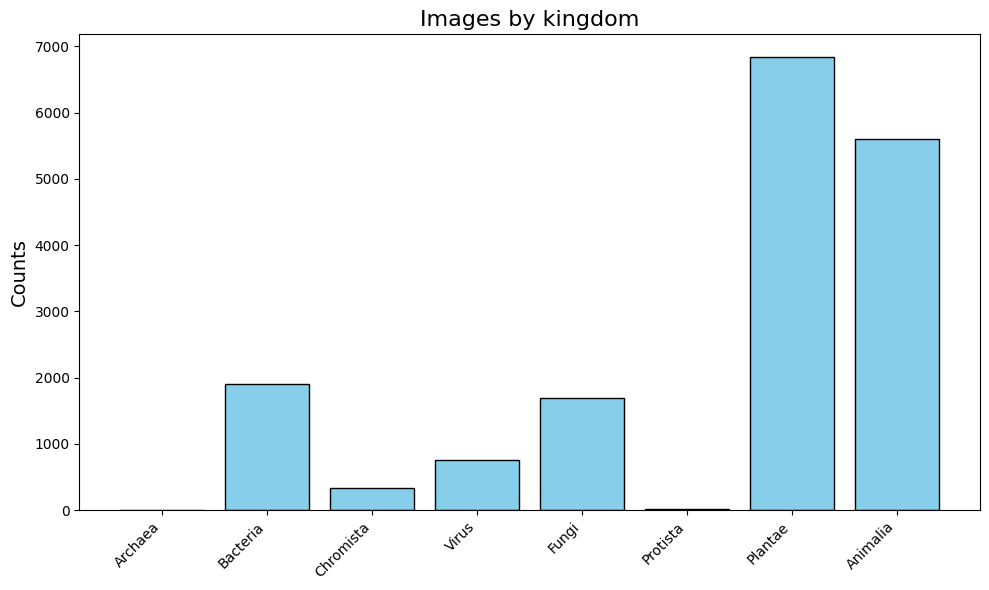

In [ ]:
plot_histogram({k if k != 'Viruses_and_viroids' else 'Virus': len(v) for k, v in EPPO_images.items()}, 'Images by kingdom')

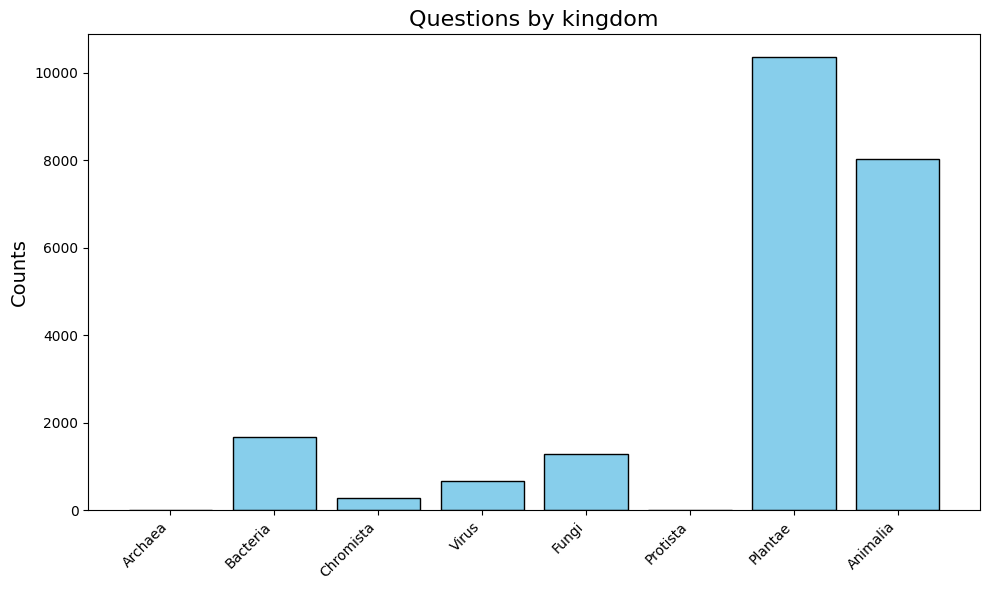

In [ ]:
plot_histogram({k if k != 'Viruses_and_viroids' else 'Virus': len(v) for k, v in questions.items()}, 'Questions by kingdom')

# PlantNet images

In [16]:
question_templates = {
    'scientific_name_1':      'What is the scientific name of the plant shown in the following image of a {organType}, taken in {gbifRegion} on {eventDate}?',
    'scientific_name_2':      'What is the scientific name of the plant shown in the following image of a {organType}, taken in {gbifRegion}?',
    'scientific_name_3':      'What is the scientific name of the plant shown in the following image of a {organType}?',
    'scientific_name_4':      'What is the scientific name of the plant shown in the following image?',
    'organ_type_1':           'What type of organ is shown in the following image of a plant with the scientific name {acceptedScientificName}, taken in {gbifRegion} on {eventDate}?',
    'organ_type_2':           'What type of organ is shown in the following image of a plant with the scientific name {acceptedScientificName}, taken in {gbifRegion}?',
    'organ_type_3':           'What type of organ is shown in the following image of a plant with the scientific name {acceptedScientificName}?',
    'organ_type_4':           'What type of organ is shown in the following image of a plant?',
    'region_1':               'In which region was the following image of a plant with the scientific name {acceptedScientificName}, taken on {eventDate}?',
    'region_2':               'In which region was the following image of a plant with the scientific name {acceptedScientificName} taken?',
    'region_3':               'In which region was the following image of a plant taken?',
    'season_1':               'On what season was the following image of a plant with the scientific name {acceptedScientificName}, taken in {gbifRegion}?',
    'season_2':               'On what season was the following image of a plant with the scientific name {acceptedScientificName} taken?',
    'season_3':               'On what season was the following image of a plant taken?'
}

In [17]:
def gbifRegionTag2Str(gbifRegion):
    if gbifRegion == 'EUROPE':
        return 'Europe'
    elif gbifRegion == 'AFRICA':
        return 'Africa'
    elif gbifRegion == 'NORTH_AMERICA':
        return 'North America'
    elif gbifRegion == 'OCEANIA':
        return 'Oceania'
    elif gbifRegion == 'LATIN_AMERICA':
        return 'South America'
    elif gbifRegion == 'ASIA':
        return 'Asia'
    else:
        return 'Unknown'

def date2Season(date):
    month = int(date.split('-')[1])
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'unknown'

In [18]:
speciesKey2Taxon = {v.gbif_key:v for v in taxons['Plantae']}
eppo2gbif = dfs['GBIF']['Plantae']
class PlantNetImage():
    def __init__(self, plantnet_row):
        self.image_path = plantnet_row['mediaIdentifier']
        self.tag = plantnet_row['organType']
        self.date = date2Season(plantnet_row['eventDate'])
        self.region = gbifRegionTag2Str(plantnet_row['gbifRegion'])
        self.eppo_row = eppo2gbif[eppo2gbif['key']==plantnet_row['speciesKey']].iloc[0] if plantnet_row['speciesKey'] in eppo2gbif['key'].values else None
        self.common_names = adjust_common_names(eval(str(self.eppo_row.get('Common names','[]'))))
        self.taxon = speciesKey2Taxon.get(plantnet_row['speciesKey'], None)
        self.time = plantnet_row['eventDate']
        self.gbifID = plantnet_row['gbifID']
       
    def __str__(self):
        # Start by defining the order of attributes
        ordered_attrs = [
            ('Image_path', self.image_path if hasattr(self, 'image_path') else None),
            ('Tag', self.tag),
            ('Date', self.date),
            ('Region', self.region),
        ]

        # Add any other attributes dynamically (if any)
        for attr in dir(self):
            if not callable(getattr(self, attr)) and not attr.startswith("__") and attr not in ['image_path', 'tag', 'date', 'region', 'correct_answer']:
                ordered_attrs.append((attr.capitalize(), getattr(self, attr)))

        # Format and return the string in the correct order
        formatted_attrs = '\n'.join(f"{key}: {value}" for key, value in ordered_attrs if value is not None)
        response = requests.get(self.image_path)
        plt.figure()
        image = Image.open(BytesIO(response.content))
        plt.imshow(image)
        plt.axis('off')  # Turn off axis labels
        plt.show()
        return formatted_attrs
    
    def valid_growth_stage(self):
        return self.tag
    
    def get_templates(self):
        return set(list(question_templates.keys()))

In [ ]:
file = '/workdir/important_datasets/PlantNet_balanced_subset.csv'
df = pd.read_csv(file)

<Axes: >

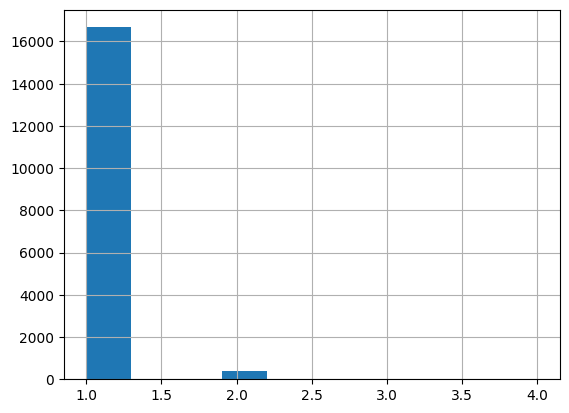

In [ ]:
# return subset of df having more than one occurrence with same 'gbifID' column
df.groupby('gbifID')['gbifID'].value_counts().hist()

<Axes: >

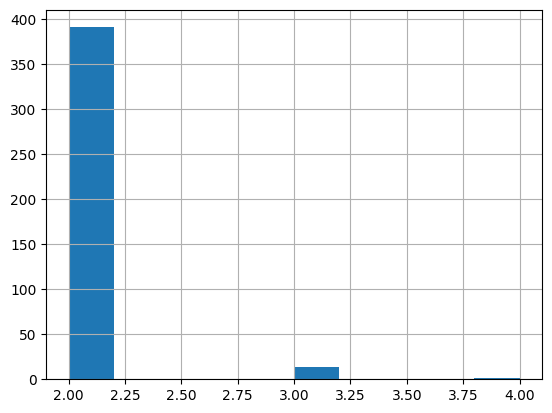

In [ ]:
df.groupby('gbifID').filter(lambda x: len(x) > 1)['gbifID'].value_counts().hist()

<Axes: >

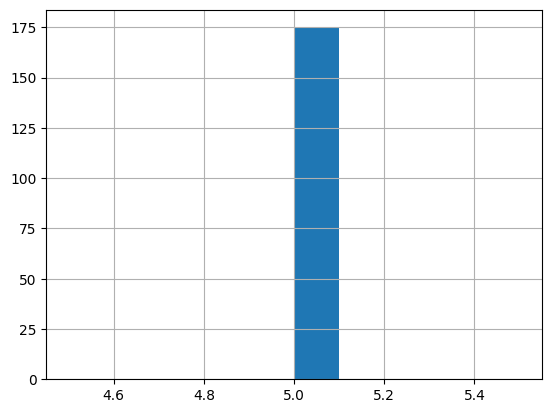

In [ ]:
# plot histogram of average organ type distribution per species
df.groupby('speciesKey')['organType'].nunique().hist()

In [ ]:
encountered_keys = {}
PlantNet_images = []

for i, row in tqdm(df.iterrows()):
    if row['speciesKey'] in speciesKey2Taxon:
        plantnet_image = PlantNetImage(row)
        PlantNet_images.append(plantnet_image)

17500it [00:24, 704.40it/s]


In [ ]:
def get_question(image, question_template, difficulty, num_options=3):
    
    image_path = image.image_path
    taxon = image.taxon
    
    if 'scientific_name' in question_template.tag:
            
        correct_answer = str(taxon.get_attr('canonicalName') if taxon.get_attr('canonicalName') else taxon.get_attr('scientificName'))
        options = taxon.get_random_neighbors(6-difficulty, num=num_options)
        if len(options) < num_options:
            return
        options.append(correct_answer)
    
    elif 'organ_type' in question_template.tag:
        
        correct_answer = image.tag
        options = ['leaf', 'flower', 'fruit', 'bark', 'habit']
                   
    elif 'region' in question_template.tag:
    
        correct_answer = image.region
        options = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
        
    elif 'season' in question_template.tag:
    
        correct_answer = image.date
        options = ['spring', 'summer', 'autumn', 'winter']
    
    shuffle(options)
    
    question_template.update(
        image=image,
        options=options, 
        correct_answer=correct_answer, 
        difficulty=difficulty, 
        image_path=image_path, 
        kingdom='Plantae',
        language='English',
        organType=image.tag,
        gbifRegion=image.region,
        eventDate=image.date,
        acceptedScientificName=str(taxon.get_attr('canonicalName') if taxon.get_attr('canonicalName') else taxon.get_attr('scientificName'))
        )
    
    return question_template

In [ ]:
errors={}
questions={}
c = 0
r = 0
tot=0
errors={}
questions=[]

for image in tqdm(PlantNet_images):
    templates=image.get_templates()
    for template in templates:
        if 'scientific_name' in template:
            for difficulty in range(3,6):
                q_temp = IdentificationQuestion(template)
                quest = get_question(image, q_temp, difficulty=difficulty)
                if quest:
                    questions.append(quest)
        else:
            q_temp = IdentificationQuestion(tag=template,question_template=question_templates[template])
            quest = get_question(image, q_temp, difficulty=1)
            if quest:
                questions.append(quest)

100%|██████████| 17300/17300 [01:38<00:00, 174.83it/s]


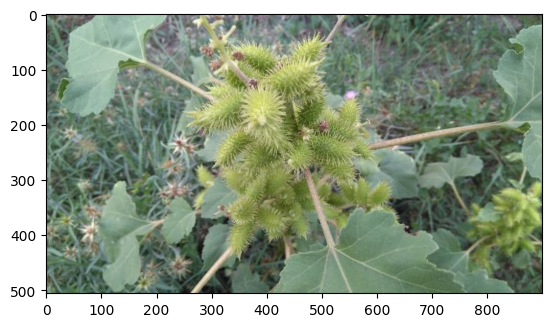

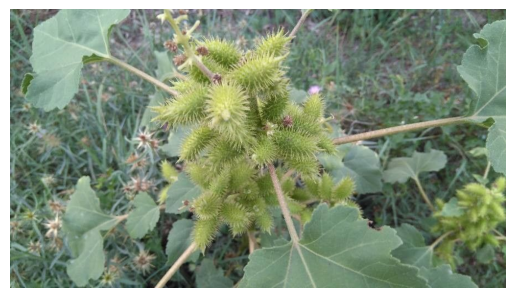

Kingdom: Plantae
Image_path: https://bs.plantnet.org/image/o/b1a54ff6fd57fbdca6cdd6fb1e250e7bef384e76
Question: What is the scientific name of the plant shown in the following image?
Options: ['Lechenaultia biloba', 'Xanthium strumarium', 'Menyanthes trifoliata', 'Donatia fascicularis']
Correct_answer: Xanthium strumarium
Acceptedscientificname: Xanthium strumarium
Difficulty: 3
Eventdate: autumn
Gbifregion: Europe
Image: Image_path: https://bs.plantnet.org/image/o/b1a54ff6fd57fbdca6cdd6fb1e250e7bef384e76
Tag: fruit
Date: autumn
Region: Europe
Common_names: {}
Eppo_row: EPPO_code                                                              XANST
speciesKey                                                           3089154
numDescendants                                                             3
descriptions               [{"description":"Africa"},{"description":"Arab...
species                                                  Xanthium strumarium
vernacularNames            [{"vernacul

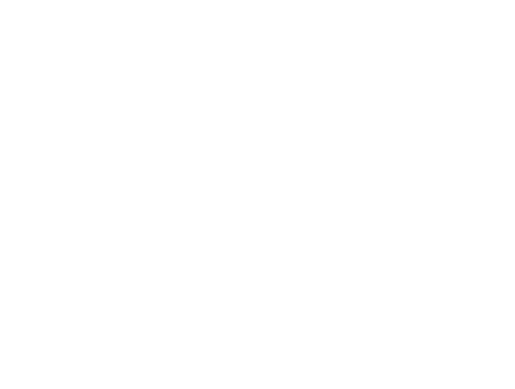

In [ ]:
for question in questions:
    if question.tag == 'scientific_name_4' and question.difficulty == 3:
        plt.imshow(Image.open(BytesIO(requests.get(question.image_path).content)))
        print(question)
        plt.axis('off')
        plt.show()
        break

In [ ]:
row = {
    "id": "_agri_identification_{number}",
    "question": "{question}",
    "options": [], 
    "explanation": "string:{explanation}",
    "image_1": "{image_1}",
    "image_2": "{image_2}",
    "image_3": "{image_3}",
    "image_4": "{image_4}",
    "image_5": "{image_5}",
    "img_type": "{img_type}",
    "answer": "{answer}",
    "topic_difficulty": "{topic_difficulty}",
    "question_type": "{question_type}",
    "subfield": "{subfield}",
    "metadata": {
        "source": "{source}",
        "author": "{author}",
        "license": "{license}",
        "url": "{url}",
        "gbif_id": "{gbif_id}",
        "eppo_code": "{eppo_code}",
        "gbif_key": "{gbif_key}",
        "kingdom": "{kingdom}",
        "tag": "{tag}",
        "region": "{region}",
        "event_date": "{event_date}",
        "language": "{language}"
    }
}

In [ ]:
def open_image(image_path):
    response = requests.get(image_path)
    image = Image.open(BytesIO(response.content))
    return image

In [ ]:
OPTIONS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
rows = []
for q in tqdm(questions):
    row['id'] = f"_agri_identification_{len(rows)+1}"
    row['question'] = q.question
    row['options'] = q.options if q.options else []
    row['explanation'] = None
    row['image_1'] = q.image_path
    row['image_2'] = None
    row['image_3'] = None
    row['image_4'] = None
    row['image_5'] = None
    row['img_type'] = 'picture'
    if q.options:
        row['answer'] = OPTIONS[q.options.index(q.correct_answer)]
        row['question_type'] = 'multiple-choice'
    else:
        row['answer'] = q.correct_answer
        row['question_type'] = 'open-ended'
    row['topic_difficulty'] = q.difficulty
    row['subfield'] = q.tag
    row['metadata']['source'] = 'PlantNet'
    row['metadata']['author'] = 'PlantNet'
    row['metadata']['license'] = 'CC BY-SA 4.0'
    row['metadata']['url'] = q.image_path
    row['metadata']['gbif_id'] = q.image.gbifID
    row['metadata']['eppo_code'] = [e['EPPO Code'] for e in q.image.taxon.eppo_list]
    row['metadata']['gbif_key'] = q.image.taxon.gbif_key
    row['metadata']['kingdom'] = 'Plantae'
    row['metadata']['tag'] = q.tag
    row['metadata']['region'] = q.gbifRegion
    row['metadata']['event_date'] = q.image.time
    row['metadata']['language'] = 'English'
    rows.append(row.copy())
    

100%|██████████| 371400/371400 [00:02<00:00, 126937.89it/s]


In [ ]:
rows[0]

{'id': '_agri_identification_1',
 'question': 'On what season was the following image of a plant with the scientific name Xanthium strumarium taken?',
 'options': ['winter', 'autumn', 'summer', 'spring'],
 'explanation': None,
 'image_1': 'https://bs.plantnet.org/image/o/b1a54ff6fd57fbdca6cdd6fb1e250e7bef384e76',
 'image_2': None,
 'image_3': None,
 'image_4': None,
 'image_5': None,
 'img_type': 'picture',
 'answer': 'B',
 'topic_difficulty': 1,
 'question_type': 'multiple-choice',
 'subfield': 'season_2',
 'metadata': {'source': 'PlantNet',
  'author': 'PlantNet',
  'license': 'CC BY-SA 4.0',
  'url': 'https://bs.plantnet.org/image/o/b7dd1cf5267956093fd79dfd5be0752d3347d631',
  'gbif_id': 3997874937,
  'eppo_code': ['IUPOO'],
  'gbif_key': 2684451,
  'kingdom': 'Plantae',
  'tag': 'organ_type_4',
  'region': 'Europe',
  'event_date': '2020-02-09T11:16:21Z',
  'language': 'English'}}

# PlantNet multi images

In [19]:
question_templates = {
    'scientific_name_4':      'What is the scientific name of the plant shown in <image 1>?',
    'scientific_name_5':      'What is the scientific name of the plant shown in <image 1><image 2><image 3>?'
}

In [20]:
file = '/workdir/important_datasets/PlantNet_balanced_subset_organs.csv'
df = pd.read_csv(file)
# return subset of df having more than one occurrence with same 'gbifID' column
df.groupby('gbifID')['gbifID'].value_counts()

gbifID
2643479815    3
2643480509    3
2643480910    3
2643481474    3
2643481740    3
             ..
3997841072    3
3997843844    3
3997844847    3
3997862735    3
3997863330    3
Name: count, Length: 1275, dtype: int64

In [21]:
encountered_keys = {}
PlantNet_observ_dict = {}
for i, row in tqdm(df.iterrows()):
    if row['speciesKey'] in speciesKey2Taxon:
        plantnet_image = PlantNetImage(row)
        if plantnet_image.gbifID in PlantNet_observ_dict:
            PlantNet_observ_dict[plantnet_image.gbifID].append(plantnet_image)
        else:
            PlantNet_observ_dict[plantnet_image.gbifID] = [plantnet_image]
        
def get_question(image, question_template, difficulty, num_options=3):
    
    image_path = image.image_path
    taxon = image.taxon
    
    if 'scientific_name' in question_template.tag:
            
        correct_answer = str(taxon.get_attr('canonicalName') if taxon.get_attr('canonicalName') else taxon.get_attr('scientificName'))
        options = taxon.get_random_neighbors(6-difficulty, num=num_options)
        if len(options) < num_options:
            return
        options.append(correct_answer)
    
    shuffle(options)
    
    question_template.update(
        image=image,
        options=options, 
        correct_answer=correct_answer, 
        difficulty=difficulty, 
        image_path=image_path, 
        kingdom='Plantae',
        language='English',
        organType=image.tag,
        gbifRegion=image.region,
        eventDate=image.date,
        acceptedScientificName=str(taxon.get_attr('canonicalName') if taxon.get_attr('canonicalName') else taxon.get_attr('scientificName'))
        )
    
    return question_template

errors={}
questions={}
c = 0
r = 0
tot=0
errors={}
questions=[]
from copy import copy
for gbifid, images in tqdm(PlantNet_observ_dict.items()):
    for difficulty in range(3,6):
        q_temp = IdentificationQuestion('scientific_name_4', question_template=question_templates['scientific_name_4'])
        quest = get_question(images[0], q_temp, difficulty=difficulty)    
        if quest:
            options = quest.options            
            for image in images:
                shuffle(options)
                quest.options = copy(options)
                quest.image_path = image.image_path
                questions.append(copy(quest))
            shuffle(options)
            quest.options = copy(options)
            quest.question = question_templates['scientific_name_5']
            quest.tag = 'scientific_name_5'
            quest.image_path = [image.image_path for image in images]
            questions.append(copy(quest))


3825it [00:05, 755.59it/s]
100%|██████████| 1230/1230 [00:01<00:00, 756.80it/s]


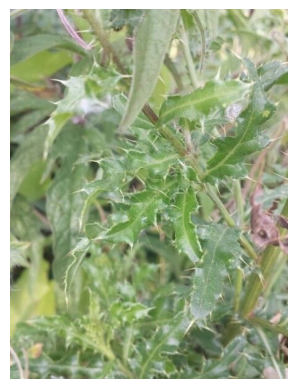

Kingdom: Plantae
Image_path: ['https://bs.plantnet.org/image/o/048ad9979b3df6bfc2efd59d73b55956382d3b54', 'https://bs.plantnet.org/image/o/43d5070f1a489b29c1f594f14063429b27b476b0', 'https://bs.plantnet.org/image/o/f969c22845ab33eebdb3a379032b8daade095ad8']
Question: What is the scientific name of the plant shown in <image 1><image 2><image 3>?
Options: ['Cirsium arvense', 'Corokia macrocarpa', 'Carpodetus serratus', 'Phelline comosa']
Correct_answer: Cirsium arvense
Acceptedscientificname: Cirsium arvense
Difficulty: 3
Eventdate: summer
Gbifregion: Europe
Image: Image_path: https://bs.plantnet.org/image/o/048ad9979b3df6bfc2efd59d73b55956382d3b54
Tag: leaf
Date: summer
Region: Europe
Common_names: {}
Eppo_row: EPPO_code                                                              CIRAR
speciesKey                                                           3113414
numDescendants                                                            11
descriptions               [{"description":"Cauca

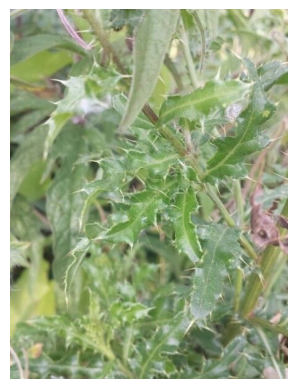

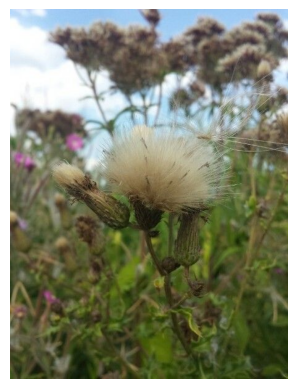

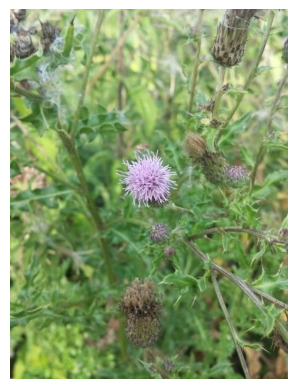

In [22]:
from PIL import Image
for question in questions:
    if question.tag == 'scientific_name_5' and question.difficulty == 3:
        print(question)
        if isinstance(question.image_path, list):
            for image_path in question.image_path:
                plt.imshow(Image.open(BytesIO(requests.get(image_path).content)))
                plt.axis('off')
                plt.show()
        else:
            plt.imshow(Image.open(BytesIO(requests.get(question.image_path).content)))
            plt.axis('off')
            plt.show()
        break

In [28]:
row = {
    "id": "_agri_identification_{number}",
    "question": "{question}",
    "options": [], 
    "explanation": "string:{explanation}",
    "image_1": "{image_1}",
    "image_2": "{image_2}",
    "image_3": "{image_3}",
    "image_4": "{image_4}",
    "image_5": "{image_5}",
    "img_type": "{img_type}",
    "answer": "{answer}",
    "topic_difficulty": "{topic_difficulty}",
    "question_type": "{question_type}",
    "subfield": "{subfield}",
    "metadata": {
        "source": "{source}",
        "author": "{author}",
        "license": "{license}",
        "url": "{url}",
        "gbif_id": "{gbif_id}",
        "eppo_code": "{eppo_code}",
        "gbif_key": "{gbif_key}",
        "kingdom": "{kingdom}",
        "tag": "{tag}",
        "region": "{region}",
        "event_date": "{event_date}",
        "language": "{language}"
    }
}


In [23]:
import os
import requests
from PIL import Image
from io import BytesIO

def image_to_byte_array(image: Image) -> bytes:
  # BytesIO is a file-like buffer stored in memory
  imgByteArr = BytesIO()
  # image.save expects a file-like as a argument
  image.save(imgByteArr, format=image.format)
  # Turn the BytesIO object back into a bytes object
  imgByteArr = imgByteArr.getvalue()
  return imgByteArr

def check_if_image_exists(image_path, save_dir):
    image_name = image_path.split('/')[-1] + '.jpg'
    image_path = os.path.join(save_dir, image_name)
    return os.path.exists(image_path)

def get_image(image_path, save_dir):
    if save_dir:
        if check_if_image_exists(image_path, save_dir):
            image = Image.open(os.path.join(save_dir, image_path.split('/')[-1] + '.jpg'))
        else:
            response = requests.get(image_path)
            image = Image.open(BytesIO(response.content))
            image.save(os.path.join(save_dir, image_path.split('/')[-1] + '.jpg'))
            
    return image_to_byte_array(image)

In [24]:
import asyncio
import aiohttp
import os

# Directory to save images
SAVE_DIR = "/workdir/images"

# Ensure the save directory exists
os.makedirs(SAVE_DIR, exist_ok=True)

async def download_image(session, url, file_path):
    """
    Downloads an image from a given URL and saves it to the specified file path.
    """
    try:
        async with session.get(url) as response:
            if response.status == 200:
                with open(file_path, 'wb') as f:
                    f.write(await response.read())
                print(f"Downloaded: {file_path}")
            else:
                print(f"Failed to download {url}: HTTP {response.status}")
    except Exception as e:
        print(f"Error downloading {url}: {e}")

async def download_images(urls):
    """
    Downloads multiple images asynchronously from a list of URLs.
    """
    async with aiohttp.ClientSession() as session:
        tasks = []
        for i, url in enumerate(urls):
            file_path=os.path.join(SAVE_DIR, url.split('/')[-1] + '.jpg')  # Adjust the extension based on the file type
            tasks.append(download_image(session, url, file_path))
        await asyncio.gather(*tasks)




In [25]:
# List of image URLs
image_urls = [question.image_path for question in questions if isinstance(question.image_path, str)]

In [ ]:
# Run the async downloader
await download_images(image_urls)

In [29]:
OPTIONS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
rows = []
from copy import deepcopy
for q in tqdm(questions[:100]):
    row['id'] = f"Identification_{len(rows)+1}"
    row['question'] = q.question
    row['options'] = q.options if q.options else []
    row['options'] = str(row['options'])
    row['explanation'] = ''
    row['image_1'] = get_image(q.image_path, SAVE_DIR) if isinstance(q.image_path, str) else None
    row['image_2'] = None
    row['image_3'] = None
    row['image_4'] = None
    row['image_5'] = None
    if isinstance(q.image_path, list):
        for path, i in zip(q.image_path, range(1,len(q.image_path)+1)):
            row[f'image_{i}'] = get_image(path, SAVE_DIR)
    row['img_type'] = str(['Picture'])
    if q.options:
        row['answer'] = OPTIONS[q.options.index(q.correct_answer)]
        row['question_type'] = 'multiple-choice'
    else:
        row['answer'] = q.correct_answer
        row['question_type'] = 'open-ended'
    row['topic_difficulty'] = q.difficulty
    row['subfield'] = q.tag
    
    row['metadata']['source'] = 'PlantNet'
    row['metadata']['author'] = 'PlantNet'
    row['metadata']['license'] = 'CC BY-SA 4.0'
    row['metadata']['url'] = q.image_path
    row['metadata']['gbif_id'] = q.image.gbifID
    row['metadata']['eppo_code'] = [e['EPPO Code'] for e in q.image.taxon.eppo_list]
    row['metadata']['gbif_key'] = q.image.taxon.gbif_key
    row['metadata']['kingdom'] = 'Plantae'
    row['metadata']['tag'] = q.tag
    row['metadata']['region'] = q.gbifRegion
    row['metadata']['event_date'] = q.image.time
    row['metadata']['language'] = 'English'
    rows.append(deepcopy(row))

100%|██████████| 100/100 [00:00<00:00, 201.01it/s]


In [30]:
# split rows in dev, validation and test sets 
import json
import numpy as np
df = pd.DataFrame(rows)
df.metadata = df.metadata.apply(json.dumps)
index = df.index.tolist()
shuffle(index)
dev, test, validate = np.split(index, [int(len(index)*0.1), int(len(index)*0.2)])

In [31]:
# overwrite row['id'] with new id {set}_Identification_{number}
df.loc[dev, 'id'] = df.loc[dev].apply(lambda x: f"dev_{x['id']}", axis=1)
df.loc[validate, 'id'] = df.loc[validate].apply(lambda x: f"validation_{x['id']}", axis=1)
df.loc[test, 'id'] = df.loc[test].apply(lambda x: f"test_{x['id']}", axis=1)

In [32]:
len(dev), len(validate), len(test)

(10, 80, 10)

In [33]:
from datasets import Features, Value, Sequence, Image, DatasetInfo

features = Features({'id': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'options': Value(dtype='string', id=None),
 'explanation': Value(dtype='string', id=None),
 'image_1': Image(decode=True, id=None),
 'image_2': Image(decode=True, id=None),
 'image_3': Image(decode=True, id=None),
 'image_4': Image(decode=True, id=None),
 'image_5': Image(decode=True, id=None),
 'img_type': Value(dtype='string', id=None),
 'answer': Value(dtype='string', id=None),
 'topic_difficulty': Value(dtype='string', id=None),
 'question_type': Value(dtype='string', id=None),
 'subfield': Value(dtype='string', id=None),
 'metadata': Value(dtype='string', id=None)})

/root/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
from datasets import Dataset

for idx in [dev, validate, test]:
    # rename id with progressive number {set}_Identification_{number}
    dev_set = df.loc[idx].copy().reset_index(drop=True)
    dev_set['index'] = range(1, len(dev_set)+1)
    dev_set['id'] = dev_set.apply(lambda x: f"{x['id'][:x['id'].rindex('_')]}_{x['index']}", axis=1)
    # remove index column
    dev_set.drop(columns=['index'], inplace=True)
    name = dev_set.id[0].split('_')[0]
    # save each batch of length 10000
    max_len = 10000
    for i in range(0, len(dev_set), max_len):
        Dataset.from_pandas(dev_set[i:i+max_len], features=features).to_parquet(f'/workdir/AGRIVQA/Identification/{name}-{str(i//max_len).zfill(5)}-of-{str((len(dev_set)//max_len)+1).zfill(5)}.parquet')


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 436.54ba/s]
